In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

# 1. Loading the dataset:

In [2]:
df = pd.read_csv("Titanic-dataset-1.csv")

## Display dataset

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Exploratory data analysis

In [4]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Survived','Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))
    
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.histplot(dataset[feature], color='g', bins=bins, ax=ax)
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(dataset[feature1].loc[dataset["Survived"] == 1],
                fill=True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[dataset["Survived"] == 0],
                fill=True, ax=ax, label="Died")
    plt.legend()
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, errorbar=None, ax=axarr).set_ylabel('Survival rate')
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)  

## 2.1 Analyze Feature Survived:

In [5]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

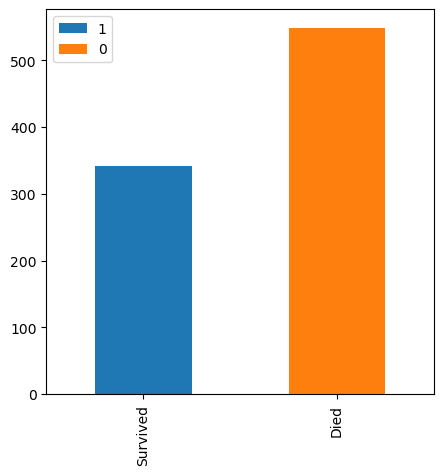

In [7]:
bar_chart_stacked(df, "Survived")

#### Observation:
Only 38% survived the disaster. So the data suffers from data imbalance.

## 2.2 Analyze Feature Gender:

In [8]:
df['Sex'].value_counts().to_frame()

,Sex
male,577
female,314


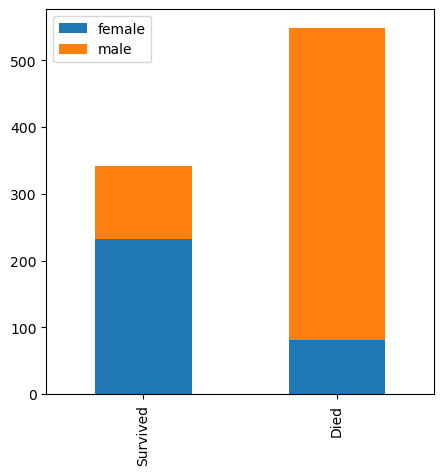

In [9]:
bar_chart_stacked(df, "Sex")

In [10]:
df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

### Observation:
The survival rate for female passengers is 4 times higher than the survival rate of male passengers even though the number of male passengers are more   

## 2.3 Analyze Feature Pclass:

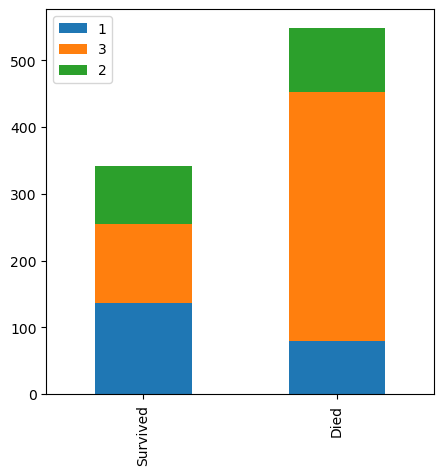

In [11]:
bar_chart_stacked(df, 'Pclass')

In [12]:
pd.pivot_table(df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [13]:
df.groupby(['Pclass']).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Observation:
- Only 24% of class 3 passengers survived, even though they are the highest in number
- Almost 63% of the passenger from class 1 survived. 
- Also approx 50% of the class 2 passenger survived.

## 2.4 Analyze Feature Pclass With Gender:

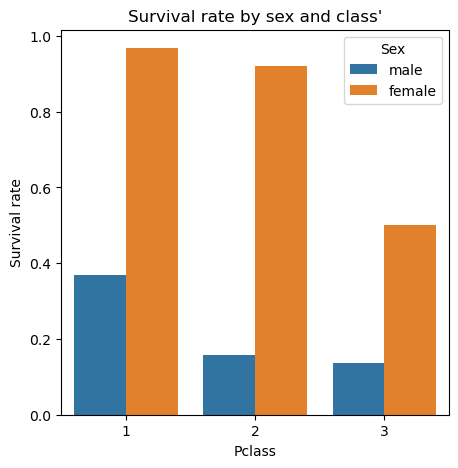

In [14]:
bar_chart_compare(df, "Pclass", "Sex")

In [15]:
pd.pivot_table(df, index = 'Survived', columns = ['Pclass', "Sex"], values = 'Ticket' ,aggfunc ='count')

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [16]:
df.groupby(['Pclass', "Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

### Observation:
The most important factor when it comes to surviving was gender irrespective of the class.
However, men in class 1 had a significantly higher chance of survival compared to other men.
- Survival Rate females 1. Class: 96,8%
- Survival Rate females 2. Class: 92,1%
- Survival Rate females 3. Class: 50% 
---------------------------------------
- Survival Rate male 1. Class: 36.8%
- Survival Rate male 2. Class: 15.8%
- Survival Rate male 3. Class: 13.6%



## 2.5 Analyze Feature Age:

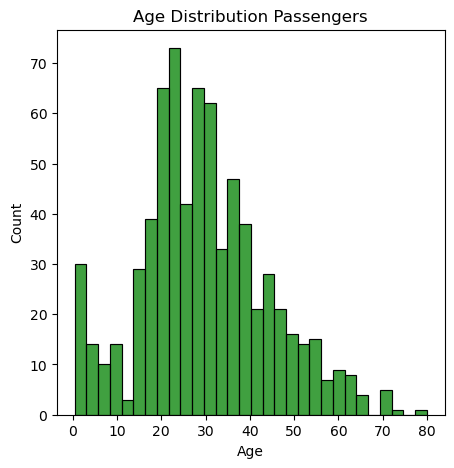

In [17]:
plot_distribution(df, "Age", "Age Distribution Passengers")

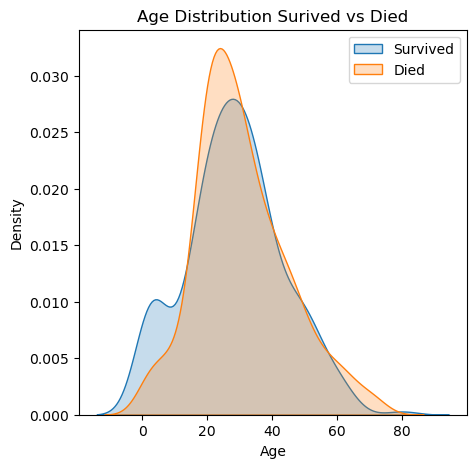

In [18]:
plot_kernel_density_estimate_survivors(df, "Age", "Age Distribution Surived vs Died")

### Observation:
The Histogram above shows that age follows a fairly normal distribution.

Also investigating the Age Distribution Surived vs Died does not provide additional information except a raise in survivors at a very young age.

## 2.6 Analyze Feature Age & Sex together:

In [19]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis.
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=dataset).set_title(title)

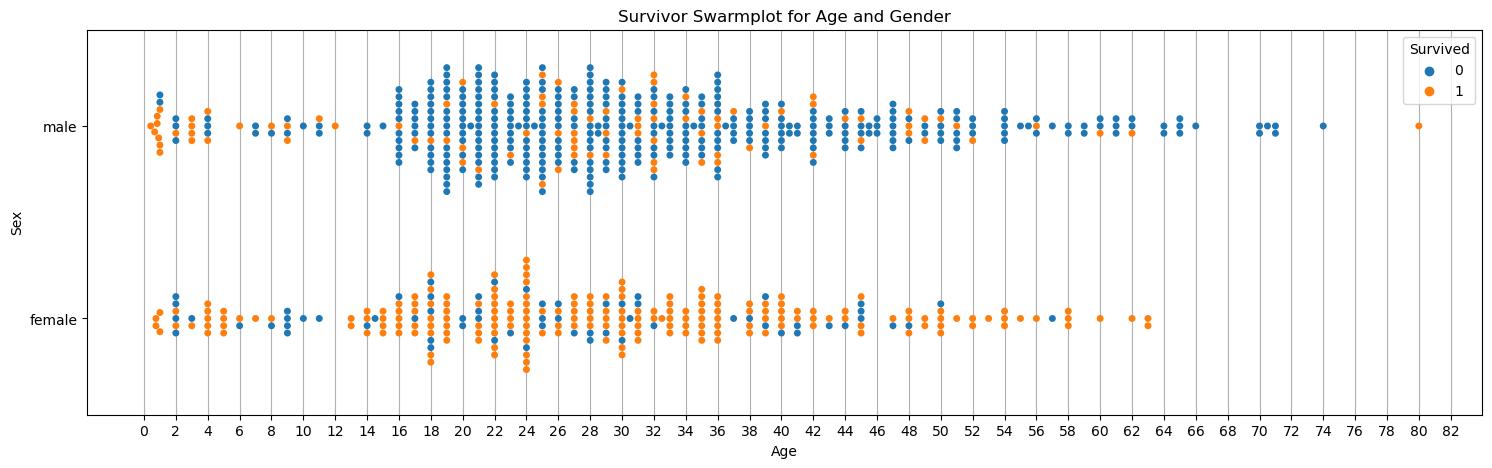

In [20]:
plot_swarm_survivors(df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

### Observation:
The swarm plot above shows that a majority of male survivors are passengers between 0 and 12 years of age.
There is also an exception the oldest passenger 80 year old man.

## 2.7 Analyze Feature Fare:

In [21]:
df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

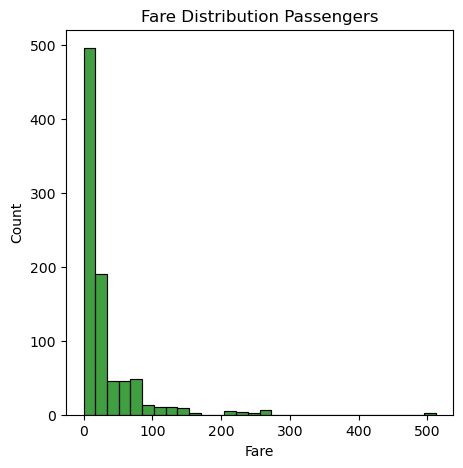

In [22]:
plot_distribution(df, "Fare", "Fare Distribution Passengers")

### Observation:
We see a huge spike at the price range [0-100$]. To get better understanding of how this affected the survivor rate, we combined fares into categories and then plot the 
categories vs Survived.


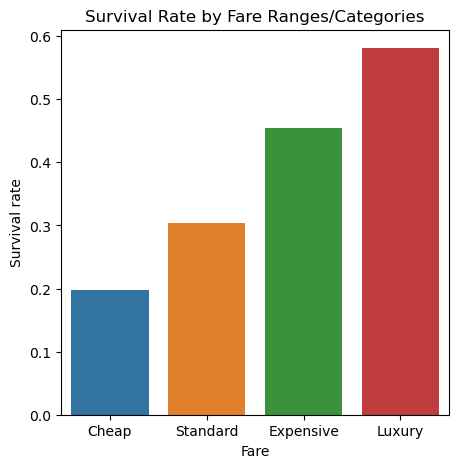

In [23]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(df, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

### Observation:
We see survival rate is surely influenced by the price paid. 
- Cheap (0-25% of max Price): Surival Rate = 0.2 (aprox)
- Standard (25%-50% of max Price): Surival Rate = 0.3 (aprox)
- Expensive (50%-75% of max Price): Surival Rate = 0.45 (aprox)
- Luxury (75%-100% of max Price): Surival Rate = 0.55 (aprox)



## 2.8 Analyze Feature Embarked

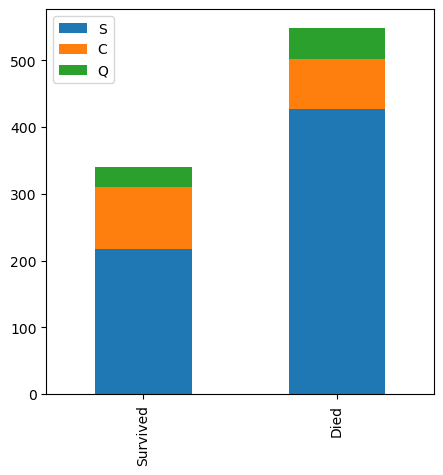

In [24]:
bar_chart_stacked(df, 'Embarked') 

In [25]:
df['Embarked'].value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


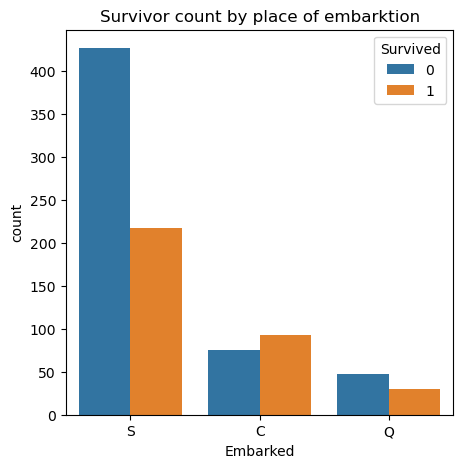

In [26]:
show_compare_countplot(df, "Embarked", "Survived", "Survivor count by place of embarktion")

In [27]:
pd.pivot_table(df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [28]:
df.groupby(['Embarked']).Survived.mean().to_frame()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


### Observation:
There are three possible values for the Embarked Feature: 
- Southampton, Cherbourg, and Queenstown.
- We see that the majority of passengers embarked from Southampton but only 33% survived.
The highest survival rate of 55% is in the group of passengers that embarked from Cherbourg

## 2.9 Analyze Features Embarked & Pclass together

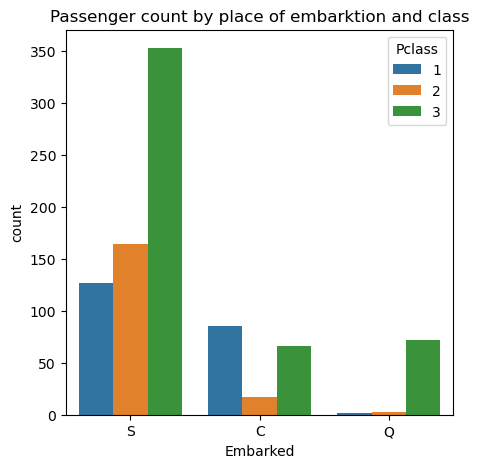

In [29]:
show_compare_countplot(df, "Embarked", "Pclass", "Passenger count by place of embarktion and class")

In [30]:
df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

### Observation:
- The majority embarked at Cherbourg were 1. class passengers.
- The majority embarked at Southampton were 3. class passengers.

However, it does not explain why the survival rate at Queenstown is slightly higher than at Southampton even though the number of 1. class passenger concerning 3. class passengers is higher at Southampton. Let us explore the gender too.

## 2.10 Analyze Features Embarked & Sex together

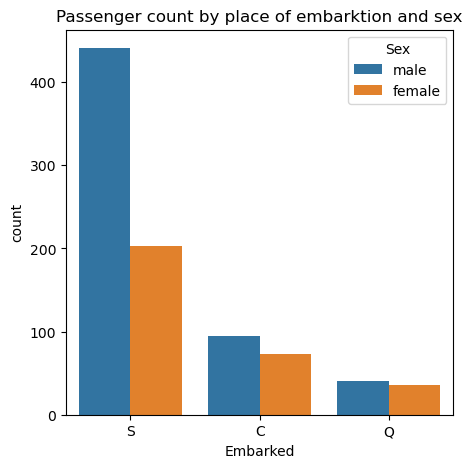

In [31]:
show_compare_countplot(df, "Embarked", "Sex", "Passenger count by place of embarktion and sex")

### Observation:
Twice as many male passengers embarked from Southam were roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.

## 2.11 Analyze Feature SibSp:
SibSp is the number of siblings or spouses of a person aboard the Titanic

In [32]:
df['SibSp'].value_counts().to_frame()

,SibSp
0,608
1,209
2,28
4,18
3,16
8,7
5,5


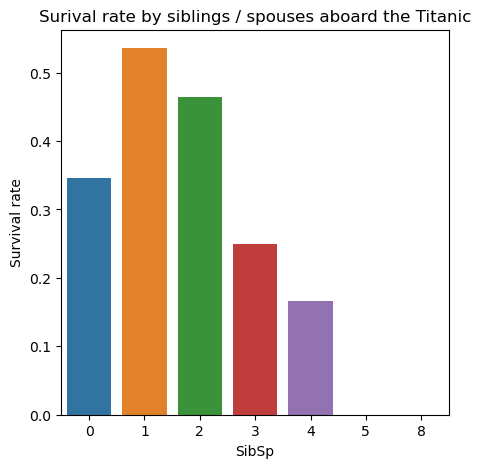

In [33]:
bar_chart_compare(df, "SibSp", title = "Surival rate by siblings / spouses aboard the Titanic")

In [34]:
df.groupby(['SibSp']).Survived.mean().to_frame()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


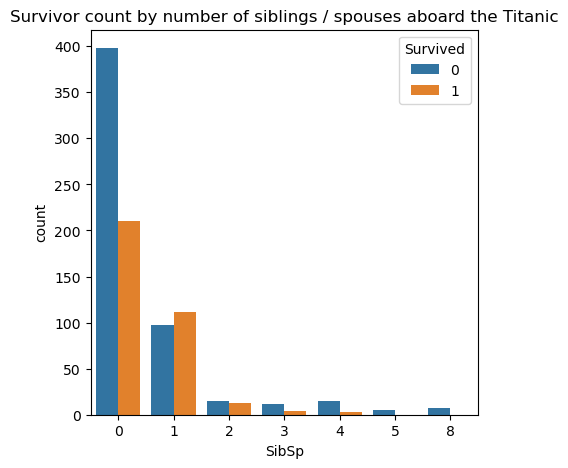

In [35]:
show_compare_countplot(df, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

### Observarion:
The majority of passemgers traveled alone.
It is observed that the more Sibling a passenger has the less chance of survival there is.

##  2.12 Analyze Feature Parch

This feature contains the number of parents or children each passenger was traveling with.

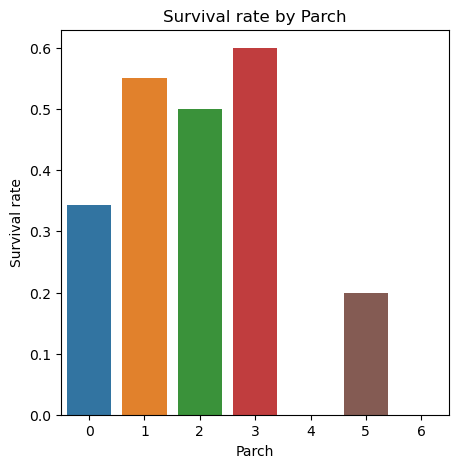

In [36]:
bar_chart_compare(df, "Parch", title = "Survival rate by Parch")

In [37]:
df.groupby(['Parch']).Survived.mean().to_frame()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


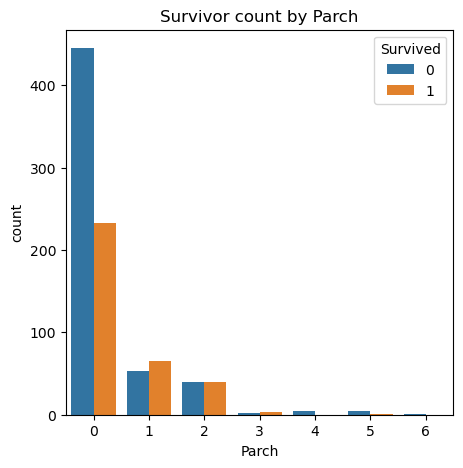

In [38]:
show_compare_countplot(df, "Parch", "Survived", "Survivor count by Parch")

### Observation:
This feature contains the number of parents or children each passenger was traveling with.
We see that small families had more chances to survive than bigger ones and passengers who traveled alone.

## 2.2 Rank Feature Importance

### Remove insignificant columns

In [39]:
y = df['Survived'] 
X = df.drop(["Survived"], axis=1)
X = X.drop(["PassengerId"], axis=1)
X = X.drop(["Name"], axis=1)
X = X.drop(["Ticket"], axis=1)
X = X.drop(["Cabin"], axis=1)


### Missing Values

In [40]:
print(X.isnull().sum())

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


### Impute missing values with median for 'Age'

In [41]:
X['Age'] = X['Age'].replace(np.NaN, X['Age'].median())

### Impute missing values with 'U' for 'Embarked'

In [42]:
X['Embarked'] = X['Embarked'].replace(np.NaN, 'U')

In [43]:
print(X.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


### Map to numeric values

In [44]:
X['Sex'] = X['Sex'].map({'male':1,'female':0})
X['Embarked'] = X['Embarked'].map({'S':0,'C':1,'Q':2,'U':-1 })
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,0
1,1,0,38.0,1,0,71.2833,1
2,3,0,26.0,0,0,7.9250,0
3,1,0,35.0,1,0,53.1000,0
4,3,1,35.0,0,0,8.0500,0


### Feature Importance

[0.10751067 0.29427011 0.24203951 0.04426467 0.04184058 0.2386158
 0.03145866]


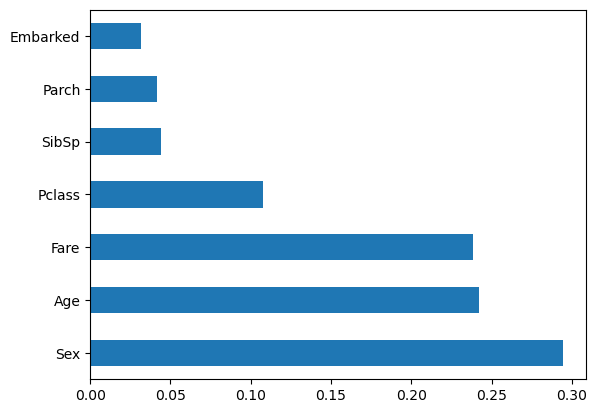

In [45]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

We see that the features are ranked as follows: Sex, Fare, Age, Pclass, SibSp, Parch, Embarked

# 3. Feature engineering

## 3.1 Feature 'Title' from 'Name':

### Observation
To create a new feature we extract the Titles from the name.

In [46]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [47]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [48]:
df['Title'].value_counts().to_frame()

,Title
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2
the Countess,1


### Observation:
The titles are severely imbalanced. Let us group less frequent Titles together by substituting male titles into Mr and female Titles into Miss.

In [49]:
df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

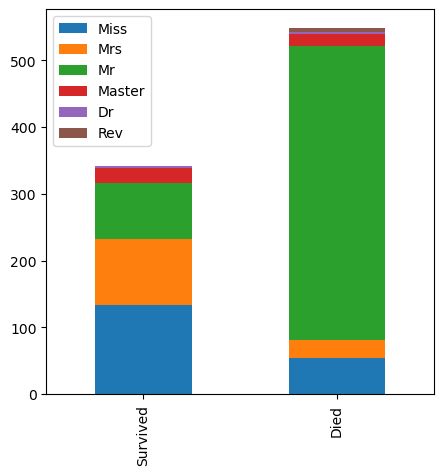

In [50]:
bar_chart_stacked(df, 'Title') 

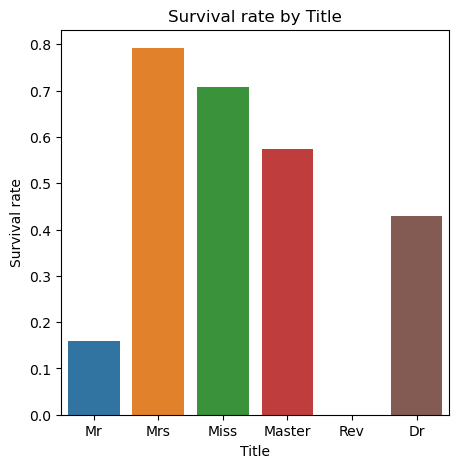

In [51]:
bar_chart_compare(df, "Title", title = "Survival rate by Title")

### Observation:
- Female Titles result in a higher survival rate.
- Master and Dr are slightly have a surprisingly high survival rate even tough both are male titles
- Being only a Mr comes with a compromised survival rate of approx 15%
- All 6 Revernands died. Maybe religious reasons caused them to sacrifice their lives for others.

## 3.2 Feature Family Size
Combine both features 'SibSp', 'Parch' into one and create a family size feature.

In [52]:
df['Fam_size'] = df['SibSp'] + df['Parch'] + 1

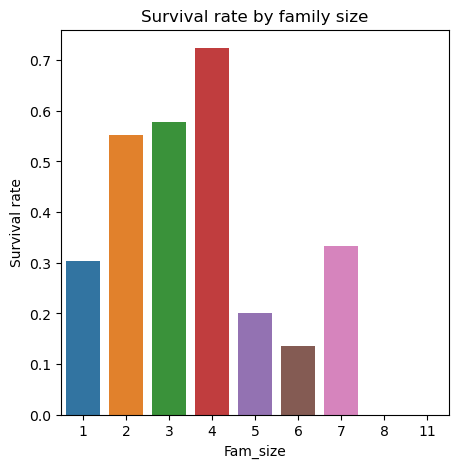

In [53]:
bar_chart_compare(df, "Fam_size", title = "Survival rate by family size")

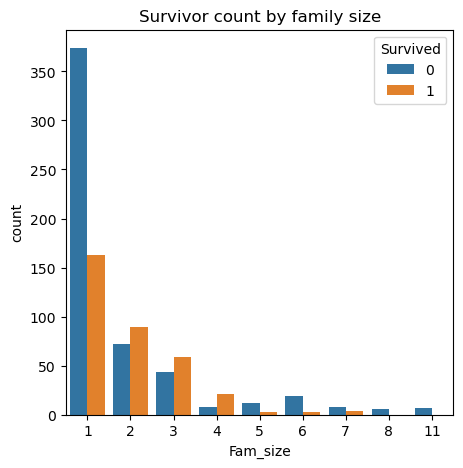

In [54]:
show_compare_countplot(df, "Fam_size", "Survived", "Survivor count by family size")

## 3.3 Feature Family Type
Create four groups for family size

In [55]:
# Creation of four groups
df['Fam_type'] = pd.cut(df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
df['Fam_type'] = pd.cut(df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

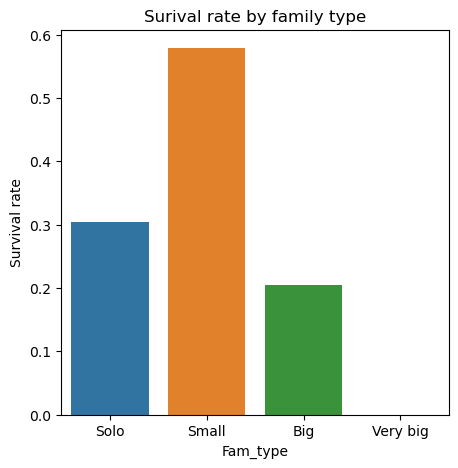

In [56]:
bar_chart_compare(df, "Fam_type", title = "Surival rate by family type")

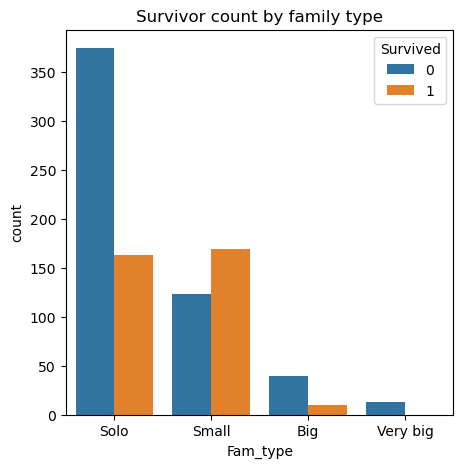

In [57]:
show_compare_countplot(df, "Fam_type", "Survived", "Survivor count by family type")

## 4. Training a classifier

- We only considered 'Pclass', 'Age', 'Fare', 'Embarked', 'Title', 'Fam_type'
- We did not use Sex as it is not useful given the Title feature.


In [58]:
def overall_model_eval(actual,pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred, average="weighted")
    precision = precision_score(actual, pred,  average="weighted")
    recall = recall_score(actual, pred,  average="weighted")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    return accuracy, f1, precision, recall

In [59]:
features = ['Pclass', 'Age', 'Fare', 'Embarked']
X = X[features]
X['Title']=df['Title']
X['Fam_type']=df['Fam_type']
X.head()

,Pclass,Age,Fare,Embarked,Title,Fam_type
0,3,22.0,7.2500,0,Mr,Small
1,1,38.0,71.2833,1,Mrs,Small
2,3,26.0,7.9250,0,Miss,Solo
3,1,35.0,53.1000,0,Mrs,Small
4,3,35.0,8.0500,0,Mr,Solo


## 4.1 Missing Values

In [60]:
print(X.isnull().sum())

Pclass      0
Age         0
Fare        0
Embarked    0
Title       0
Fam_type    0
dtype: int64


## One-Hot Encoding of Categorical Column Using Pandas library

In [61]:
one_hot_encoded_data = pd.get_dummies(X, columns = ['Title', 'Fam_type', 'Embarked']) 
print(one_hot_encoded_data)

     Pclass   Age     Fare  Title_Dr  Title_Master  Title_Miss  Title_Mr  \
0         3  22.0   7.2500         0             0           0         1   
1         1  38.0  71.2833         0             0           0         0   
2         3  26.0   7.9250         0             0           1         0   
3         1  35.0  53.1000         0             0           0         0   
4         3  35.0   8.0500         0             0           0         1   
..      ...   ...      ...       ...           ...         ...       ...   
886       2  27.0  13.0000         0             0           0         0   
887       1  19.0  30.0000         0             0           1         0   
888       3  28.0  23.4500         0             0           1         0   
889       1  26.0  30.0000         0             0           0         1   
890       3  32.0   7.7500         0             0           0         1   

     Title_Mrs  Title_Rev  Fam_type_Solo  Fam_type_Small  Fam_type_Big  \
0            

## Train - Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_data, y, test_size=0.25, random_state=42)

## Training a classifier

In [63]:
model = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5)
model.fit(X_train,y_train)


RandomForestClassifier(max_depth=5, n_estimators=500, random_state=0)

In [64]:
y_scores = cross_val_score(model, X_train, y_train, cv=10)

In [65]:
y_scores

array([0.8358209 , 0.74626866, 0.86567164, 0.92537313, 0.8358209 ,
       0.74626866, 0.80597015, 0.80597015, 0.78787879, 0.92424242])

In [66]:
print('Cross validation score: {:.3f}'.format(cross_val_score(model, X_train, y_train, cv=10).mean()))

Cross validation score: 0.828


In [67]:
y_pred = model.predict(X_test)

In [68]:
overall_model_eval(y_test, y_pred)   

Accuracy: 0.8295964125560538
F1 Score: 0.8280565335902347
Precision: 0.8287636464861248
Recall: 0.8295964125560538


(0.8295964125560538,
 0.8280565335902347,
 0.8287636464861248,
 0.8295964125560538)

We used the random forest classifier to predict if a traveller survived or not. We get a good accuracy of about 83%.